# The heat equation in 1D

$$
\renewcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\renewcommand{\drondt}{\partial_t}
\renewcommand{\drondx}{\partial_x}
\renewcommand{\drondtt}{\partial_{tt}}
\renewcommand{\drondxx}{\partial_{xx}}
\renewcommand{\drondyy}{\partial_{yy}}
\renewcommand{\dx}{\Delta x}
\renewcommand{\dt}{\Delta t}
\renewcommand{\grandO}{{\mathcal O}}
\renewcommand{\density}[2]{\,f_{#1}^{#2}}
\renewcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\renewcommand{\fks}[1]{\density{#1}{\star}}
\renewcommand{\moment}[2]{\,m_{#1}^{#2}}
\renewcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\renewcommand{\mke}[1]{\moment{#1}{e}}
\renewcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this tutorial, we test a very classical lattice Boltzmann scheme $\DdQq{1}{3}$ on the heat equation.

The problem reads
$$
\begin{gathered} \drondt u = \mu \drondxx u, \quad t>0, \quad x\in(0,1),\\ u(0) = u(1) = 0, \end{gathered}
$$
where $\mu$ is a constant scalar.

In [1]:
import sympy as sp
import numpy as np
import pyLBM

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## The scheme $\DdQq{1}{3}$

The numerical simulation of this equation by a lattice Boltzmann scheme consists in the approximatation of the solution on discret points of $(0,1)$ at discret instants.

To simulate this system of equations, we use the $\DdQq{1}{3}$ scheme given by

* three velocities $v_0=0$, $v_1=1$, and $v_2=-1$, with associated distribution functions $\fk{0}$, $\fk{1}$, and $\fk{2}$,
* a space step $\dx$ and a time step $\dt$, the ration $\lambda=\dx/\dt$ is called the scheme velocity,
* three moments
  $$ \mk{0}=\sum_{i=0}^{2} \fk{i}, \quad \mk{1}= \sum_{i=0}^{2} v_i \fk{i}, \quad \mk{2}= \frac{1}{2} \sum_{i=0}^{2} v_i^2 \fk{i},$$
  
  and their equilibrium values $\mke{0}$, $\mke{1}$, and $\mke{2}$.
* two relaxation parameters $s_1$ and $s_2$ lying in $[0,2]$.

In order to use the formalism of the package pyLBM, we introduce the three polynomials that define the moments: $P_0 = 1$, $P_1=X$, and $P_2=X^2/2$, such that
$$ \mk{k} = \sum_{i=0}^2 P_k(v_i) \fk{i}.$$

The transformation $(\fk{0}, \fk{1}, \fk{2})\mapsto(\mk{0},\mk{1}, \mk{2})$ is invertible if, and only if, the polynomials $(P_0,P_1,P_2)$ is a free set over the stencil of velocities.

The lattice Boltzmann method consists to compute the distribution functions $\fk{0}$, $\fk{1}$, and $\fk{2}$ in each point of the lattice $x$ and at each time $t^n=n\dt$.
A step of the scheme can be read as a splitting between the relaxation phase and the transport phase:

* relaxation: 
$$
    \begin{aligned}\mks{1}(t,x)&=(1-s_1)\mk{1}(t,x)+s_1\mke{1}(t,x),\\ \mks{2}(t,x)&=(1-s_2)\mk{2}(t,x)+s_2\mke{2}(t,x).\end{aligned}
$$    

* m2f: 
$$
    \begin{aligned}\fks{0}(t,x)&\;=\mk{0}(t,x)-2\mks{2}(t,x), \\ \fks{1}(t,x)&\;=\mks{1}(t,x)/2+\mks{2}(t,x), \\ \fks{2}(t,x)&\;=-\mks{1}(t,x)/2+\mks{2}(t,x).\end{aligned}
    $$

* transport: 
$$
    \begin{aligned} \fk{0}(t+\dt, x)&\;=\fks{0}(t,x), \\ \fk{1}(t+\dt, x)&\;=\fks{1}(t,x-\dx), \\ \fk{2}(t+\dt, x)&\;=\fks{2}(t,x+\dx). \end{aligned}
    $$

* f2m:
$$
    \begin{aligned}\mk{0}(t+\dt,x)&\;=\fk{0}(t+\dt,x)+\fk{1}(t+\dt,x)+\fk{2}(t+\dt,x), \\ \mk{1}(t+\dt,x)&\;=\fk{1}(t+\dt,x)-\fk{2}(t+\dt,x), \\ \mk{2}(t+\dt,x)&\;=\tfrac{1}{2}\fk{1}(t+\dt,x)+\tfrac{1}{2}\fk{2}(t+\dt,x).\end{aligned}
$$

The moment of order $0$, $\mk{0}$, being conserved during the relaxation phase, 
a diffusive scaling $\dt=\dx^2$, yields to the following equivalent equation
$$\drondt\mk{0} = 2\bigl(\tfrac{1}{s_1}-\tfrac{1}{2}\bigr) \drondxx\mke{2} + \grandO(\dx^2),$$

if $\mke{1}=0$.
In order to be consistent with the heat equation, the following choice is done:
$$\mke{2}=\tfrac{1}{2}u, \qquad s_1 = \frac{2}{1+2\mu}, \qquad s_2=1.$$


In [2]:
##########################################################
#                 physical parameters                    #
##########################################################
xmin, xmax = 0., 1. # bounds of the domain
mu = 1.             # Fourier coefficient
Tf = .1             # final time
k = 1               # number of the wave

##########################################################
#                   exact solution                       #
##########################################################
def solution(x, t, k):
    return np.sin(np.pi*k*x)*np.exp(-np.pi**2*k**2*mu*t)

##########################################################
#              parameters of the simulation              #
##########################################################
N = 10               # number of points in space
dx = (xmax-xmin)/N   # spatial step
la = 1./dx           # diffusive scaling
s1 = 2./(1+2*mu)     # relaxation parameter for m[1]
s2 = 1.              # relaxation parameter for m[2]

## Using pyLBM

pyLBM uses Python dictionary to describe the simulation. In the following, we will build this dictionary step by step.

### The geometry

In pyLBM, the geometry is defined by a box and a label for the boundaries.

Geometry informations
	 spatial dimension: 1
	 bounds of the box: 
[[ 0.  1.]]



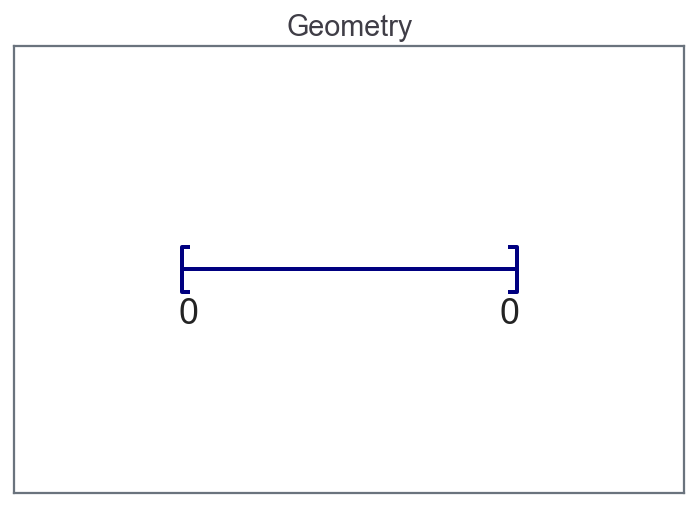

In [3]:
dico_geom = {
    'box': {
        'x': [xmin, xmax], 
        'label':0,
    },
}
geom = pyLBM.Geometry(dico_geom)
print(geom)
geom.visualize(viewlabel=True)

### The stencil

pyLBM provides a class stencil that is used to define the discret velocities of the scheme. In this example, the stencil is composed by the velocities $v_0=0$, $v_1=1$ and $v_2=-1$ numbered by $[0,1,2]$.

Stencil informations
	 * spatial dimension: 1
	 * maximal velocity in each direction: [1]
	 * minimal velocity in each direction: [-1]
	 * Informations for each elementary stencil:
		stencil 0
		 - number of velocities:  3
		 - velocities: (0: 0), (1: 1), (2: -1), 



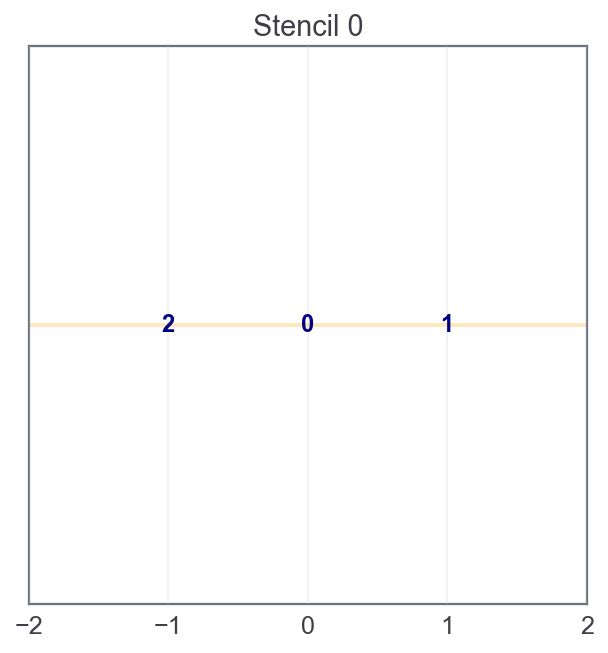

In [4]:
dico_sten = {
    'dim': 1,
    'schemes': [
        {
            'velocities': list(range(3)),
        },
    ],
}
sten = pyLBM.Stencil(dico_sten)
print(sten)
sten.visualize()

### The domain

In order to build the domain of the simulation, the dictionary should contain the space step $\dx$ and the stencils of the velocities (one for each scheme). 

We construct a domain with $N=10$ points in space.

Domain informations
	 spatial dimension: 1
	 space step: dx= 1.000e-01



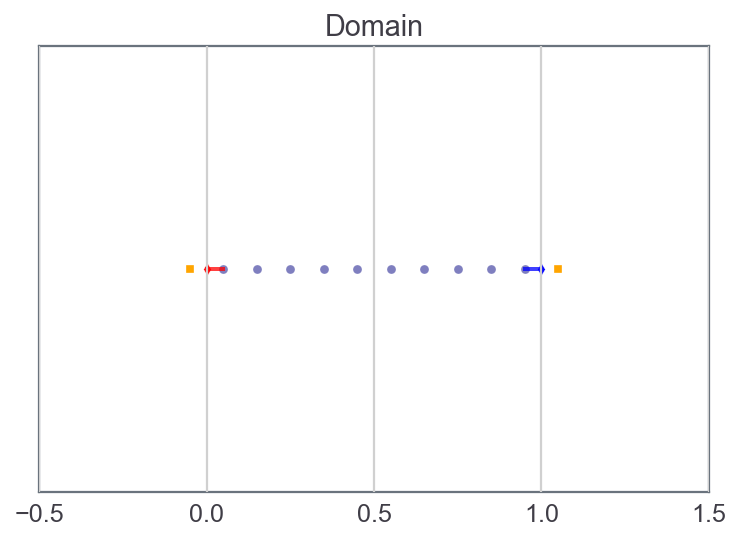

In [5]:
dico_dom = {
    'box': {
        'x': [xmin, xmax], 
        'label':0,
    },
    'space_step': dx,
    'schemes': [
        {
            'velocities':list(range(3)),
        }
    ],
}
dom = pyLBM.Domain(dico_dom)
print(dom)
dom.visualize(view_bound = True, view_distance = True)

### The scheme

In pyLBM, a simulation can be performed by using several coupled schemes. In this example, a single scheme is used and defined through a list of one single dictionary. This dictionary should contain:

* 'velocities': a list of the velocities
* 'conserved_moments': a list of the conserved moments as sympy variables
* 'polynomials': a list of the polynomials that define the moments
* 'equilibrium': a list of the equilibrium value of all the moments
* 'relaxation_parameters': a list of the relaxation parameters ($0$ for the conserved moments)
* 'init': a dictionary to initialize the conserved moments

(see the documentation for more details)

The scheme velocity could be taken to $1/\dx$ and the inital value of $u$ to

$$ u(t=0,x) = \sin(\pi x).$$

In [6]:
# symbolic variables
u, X, LA = sp.symbols('u, X, LA')

dico = {
    'box': {'x': [xmin, xmax], 'label':0},
    'space_step':dx,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities': list(range(3)),
            'conserved_moments': u,
            'polynomials': [1, X/LA, X**2/(2*LA**2)],
            'equilibrium': [u, 0., .5*u],
            'relaxation_parameters': [0., s1, s2],
            'init': {u: (solution,(0.,k))},
        }
    ],
    'boundary_conditions': {
        0: {'method': {0: pyLBM.bc.anti_bounce_back,}, 'value': None},
    },
    'show_code': True,
    'parameters': {LA: la},
}
sch = pyLBM.Scheme(dico)
print(sch)

Scheme informations
	 spatial dimension: dim=1
	 number of schemes: nscheme=1
	 number of velocities:
    Stencil.nv[0]=3
	 velocities value:
    v[0] = (0: 0), (1: 1), (2: -1), 
	 polynomials:
    P[0] = 1, X/LA, X**2/(2*LA**2), 
	 equilibria:
    EQ[0] = u, 0.0, 0.5*u, 
	 relaxation parameters:
    s[0] = 0.0, 0.666666666666667, 1.00000000000000, 
	 moments matrices
M      = Matrix([[1, 1, 1], [0, 10.0/LA, -10.0/LA], [0, 50.0/LA**2, 50.0/LA**2]])
M^(-1) = Matrix([[1, 0, -0.02*LA**2], [0, 0.05*LA, 0.01*LA**2], [0, -0.05*LA, 0.01*LA**2]])



### The simulation

A simulation is built by defining a correct dictionary.

We combine the previous dictionaries to build a simulation. In order to impose the homogeneous Dirichlet conditions in $x=0$ and $x=1$, the dictionary should contain the key 'boundary_conditions' (we use pyLBM.bc.Anti_bounce_back function).

In [7]:
sol = pyLBM.Simulation(dico)

#!python
#cython: boundscheck=False
#cython: wraparound=False
#cython: cdivision=True
#cython: binding=True
#import cython
from libc.math cimport *


def f2m(double[:, ::1] f, int nx, double[:, ::1] m):
    cdef int ix

    for ix in range(0, nx):
        m[ix, 0] = f[ix, 0] + f[ix, 1] + f[ix, 2]
        m[ix, 1] = 1.0*f[ix, 1] - 1.0*f[ix, 2]
        m[ix, 2] = 0.5*f[ix, 1] + 0.5*f[ix, 2]
    #end
#end
def m2f(double[:, ::1] m, int nx, double[:, ::1] f):
    cdef int ix

    for ix in range(0, nx):
        f[ix, 0] = m[ix, 0] - 2.0*m[ix, 2]
        f[ix, 1] = 0.5*m[ix, 1] + 1.0*m[ix, 2]
        f[ix, 2] = -0.5*m[ix, 1] + 1.0*m[ix, 2]
    #end
#end
def equilibrium(int nx, double[:, ::1] m):
    cdef int ix

    for ix in range(0, nx):

        m[ix, 1] = 0
        m[ix, 2] = 0.5*m[ix, 0]
    #end
#end
def one_time_step(double[:, ::1] f, double[::1] in_or_out, int nx, double[:, ::1] f_new):
    cdef double m[3]
    cdef int ix

    for ix in range(1, nx - 1):
        if in_or_out[ix] == 

### Run a simulation

Once the simulation is initialized, one time step can be performed by using the function one_time_step.

We compute the solution of the heat equation at $t=0.1$. And, on the same graphic, we plot the initial condition, the exact solution and the numerical solution.

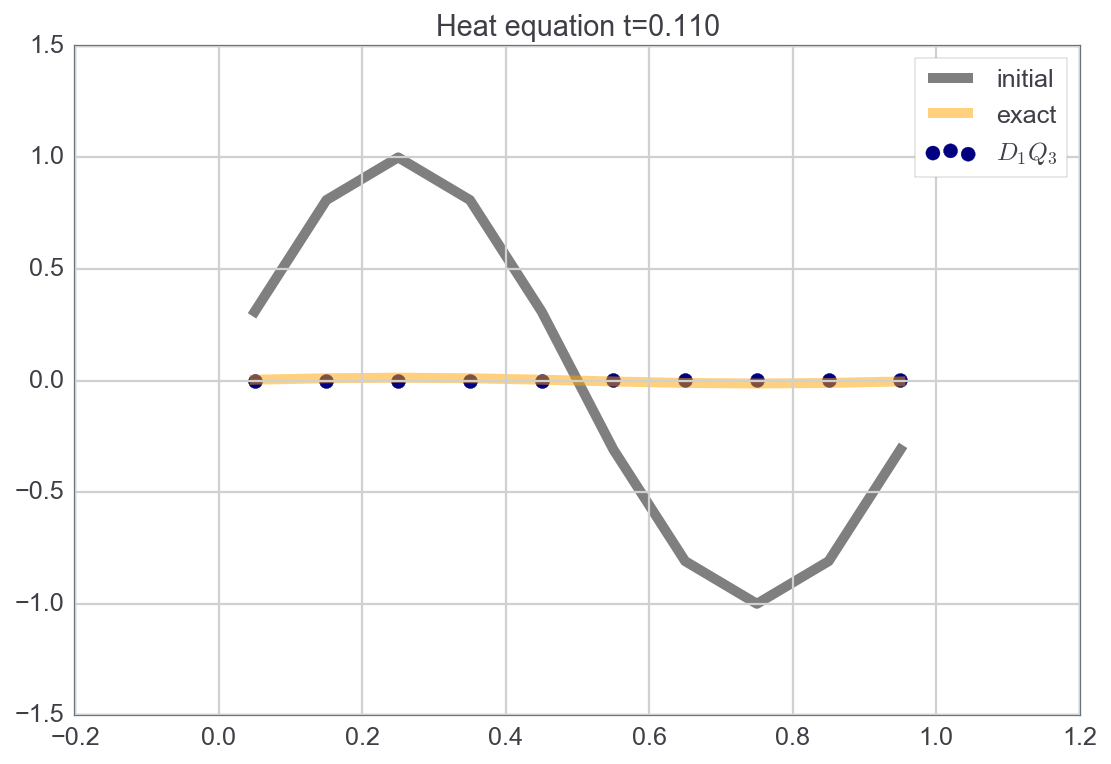

In [8]:
x = sol.domain.x

plt.figure(1, figsize=(9,6))
plt.plot(x, sol.m[u], color='black', linewidth=5, alpha=0.5, label='initial')

while sol.t < Tf:
    sol.one_time_step()

plt.plot(x, solution(x, sol.t,k),color='orange', linewidth=5, alpha=0.5, label='exact')
plt.scatter(x, sol.m[u], color='navy', s=50, alpha=1., label=r'$D_1Q_3$')

plt.title('Heat equation t={0:5.3f}'.format(sol.t))
plt.legend()